Objectives for this notebooks are:
* Create Whales
* When do bubbles emerge? And when does wyckoff dynamic emerge?

In [1]:
%run _config.ipynb

### Model Methods

In [2]:
def change_Prices(model):
    agent_wealth = [agent.wealth for agent in model.schedule.agents]
    agent_positions = [agent.position for agent in model.schedule.agents]
    agent_orders = [agent.order for agent in model.schedule.agents]
    
    sbo = 0 # sum buy orders
    sso = 0 # sum sell orders
    
    for i in range(len(agent_positions)):
        if agent_positions[i] == 'long':
            sbo += agent_orders[i]
        elif agent_positions[i] == 'short':
            sso += agent_orders[i]
    
    alfa = model.Price * model.mu # coefficient for price updating
    delta = alfa * (sbo - sso)
    
    if (sbo - sso) < -1./model.mu: # condition where prices get negative because of big orders when price is 10^-6 e.g.
        print(f'sbo: {sbo}')
        print(f'sso: {sso}')
        model.Price = 0
        model.Last_Price = 0
    else:
        model.Last_Price = model.Price
        model.Price = model.Price + delta
    
    return model.Price

In [3]:
def map_ind2name(list_tups, dic):
    list_edges_id = list()
    for (u, v) in list_tups:
        list_edges_id.append( (dic.get(u), dic.get(v)) )
    return list_edges_id

In [4]:
# INIT WITH Barabàsi-Albert
def get_BA_mapped_edges(N_whales, N_sharks, N_fishes, N_init_edges, labels):
    BA = nx.barabasi_albert_graph(N_whales + N_sharks + N_fishes, N_init_edges)
    list_idx_edges = list(BA.edges())
    
    dic = dict()
    for i in range(N_whales + N_sharks + N_fishes):
        if i < N_whales:
            dic.update({i: f'whale_{i}'})
        elif i < N_whales + N_sharks:
            dic.update({i: f'shark_{i - N_whales}'})
        else:
            dic.update({i: f'fish_{i - N_whales - N_sharks}'})
            
    list_edges = map_ind2name(list_idx_edges, dic)
    mapped_edges = list()
    for edge in list_edges:
        node1 = list(labels.keys())[list(labels.values()).index(f'{edge[0]}')]
        node2 = list(labels.keys())[list(labels.values()).index(f'{edge[1]}')]
        mapped_edges.append((node1, node2))
        
    return mapped_edges

In [5]:
def synch_coeff_sign(u, v):
    u_pv = (u.last_wealth - u.wealth)/u.wealth
    v_pv = (v.last_wealth - v.wealth)/v.wealth
    
    if u_pv*v_pv > 0:
        return 0.10
    elif u_pv*v_pv < 0:
        return -0.10
    else:
        return random.uniform(-0.02, 0.02)

### Plot Methods

In [6]:
def get_graphlabels(ordered_dict):
    inv_dict = dict(zip(ordered_dict.values(), ordered_dict.keys()))
    return inv_dict

In [7]:
def plot_graph(schedule):
    G = schedule.net
    pos = nx.spring_layout(G, k = 1)
    labels = get_graphlabels(schedule._agents)

    plt.figure(figsize=(10, 6))
    s = nx.draw_networkx_nodes(
        G,
        pos,
        node_size = 200,
        node_color = list(dict(nx.degree(G)).values()),
        alpha = 1,
        cmap = plt.cm.BuGn
    )
    
    edge_labels = {e: round(G.edges[e]['weight'], 2) for e in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 6)
    
    nx.draw_networkx_edges(G, pos, alpha=0.1)
    nx.draw_networkx_labels(G, pos, labels, font_size=8, bbox=dict(facecolor='white', edgecolor='none', alpha=0.4, pad=0.5))

    #show the colorbar on the right side
    cbar = plt.colorbar(s)
    cbar.ax.set_ylabel('Degree', size=14)

    plt.axis('off')
    plt.show();

### General Agent's Methods

In [8]:
def sample_from_dict(dic, n):
    keys = random.sample(list(dic), n)
    return {k: dic[k] for k in keys}

def get_neighbors(dict_agents, agent_id, n):
    dict_agents.pop(agent_id, None) # always exclude himself from the list before taking the sample
    return sample_from_dict(dict_agents, n) # take a sample of n agents

In [9]:
def calculate_profit(init_price, position, shares, price_today):
    # distinction on long and short positions
    if position == 'long':
        return shares * price_today
    elif position == 'short':
        return shares * (2 * init_price - price_today)

In [10]:
def update_wealth(cash, wallet, price_today):
    # wallet is a dic {'step_0': [init_price, position, quantity], 'step_1': [...], ...}
    # for each key one wants to calculate profit now by 
    balance = 0
    keys = list(wallet.keys())
    for key in keys:
        balance += calculate_profit(wallet[key][0], wallet[key][1], wallet[key][2], price_today)
        
    return cash + balance

In [11]:
# For solving negative prices problem, so the exchange puts a limit on short orders
def set_order(cash, price, risk, position, limit):
    order = risk * cash / price # risk is a % of cash to invest
    if position == 'short' and order > limit:
        order = limit
    return order

### Fish Agent

In [12]:
def add_friends(dict_neighbors, self_node):
    node_neighbors = dict_neighbors.values() # e.g. [<__main__.Agent object at 0x7f64f5ca7910>, <__main__.Agent object at 0x7f64f3ca8110>]
    
    tuple_links = list()
    for neighbour_node in node_neighbors:
        tuple_links.append((self_node, neighbour_node, random.uniform(0.50, 0.99)))
    
    return tuple_links

In [13]:
def remove_friends(G, self_node, trust_thr):
    my_edges = list(G.edges(self_node, data = True))
    
    tuple_links_to_remove = list()
    for edge in my_edges:
        if edge[2]['weight'] < trust_thr: # If weight of friend is less than my desired threshold i remove him from friends list
            tuple_links_to_remove.append((self_node, edge[1]))
    
    return tuple_links_to_remove

In [14]:
def check_socials(G, self_node):
    friends_positions = list()
    friends_trust = list()
    for (u, v) in G.edges(self_node):
        friends_trust.append(G.edges[u, v]['weight'])
        friends_positions.append(v.position)

    df_friends = pd.DataFrame(zip(friends_positions, friends_trust), columns = ['pos', 'trust'])
    
    points = list()
    pos = ['null', 'long', 'short']
    for p in pos:
        points.append(df_friends[ df_friends['pos'] == p ]['trust'].sum())
    
    return pos[points.index(max(points))]

In [15]:
def add_new_order(wallet, step, price, position, order):
    # wallet is a dictionary {'step': [price, position, order]}
    wallet |= {f'step_{step}': [price, position, order]}
    return wallet

In [16]:
def remove_orders(wallet, cash, price_today, n_orders, positions_to_sell):
    l = list()
    cash_out = 0; shares = 0
    for key, value in wallet.items():
        if value[1] == positions_to_sell:
            l.append(key)
            # calculate profit and add to cash for that key
            cash_out += calculate_profit(value[0], value[1], value[2], price_today)
            shares += value[2]
            
    cash += cash_out # convert position in cash and delete key from positions book
    for key in l:
        del wallet[key]
    
    return wallet, cash, shares

In [76]:
class Fish(mesa.Agent):
    def __init__(self, unique_id, model, init_cash, mean_trust_thr, prob_tobe_influenced, prob_update_friends):
        super().__init__(unique_id, model)
        
        # ID's
        self.type = 'fish'
        self.unique_id = unique_id
        self.node_id = None
        
        # Agent
        self.cash = round(init_cash * ( 1. + 0.5 * random.uniform(-1, 1) ), 2)
        self.wallet = dict()
        self.wealth = self.cash; self.last_wealth = self.wealth
        self.trust_thr = round(mean_trust_thr * ( 1. + 0.5 * random.uniform(-1, 1) ), 2)
        self.prob_tobe_influenced = prob_tobe_influenced
        self.prob_update_friends = prob_update_friends
        
        self.position = 'null'
        self.position_to_sell = 'null'
        self.order = 0
        
        # Agent's Thresholds
        self.cash_thr = round(200 * ( 1. + 0.5 * random.uniform(-1, 1) ), 2) # This is not a real DOF
        self.survive_mode = False
        self.sleep_mode = False
        
        # Knowledge Base
        self.neighbors = dict()
        self.influence = str() # it's the most chosen friend's position
        self.Price = None
        
    # ~-~-~-~-~-~-~-~- functions ~-~-~-~-~-~-~-~-
    
    def rnd_trade(self):
        if random.uniform(0,1) < 0.5:
            self.position = 'long'
            self.order = set_order(self.cash, self.Price, random.uniform(0.0003, 0.003), self.position, self.model.limit)
        else:
            self.position = 'short'
            self.order = set_order(self.cash, self.Price, random.uniform(0.0003, 0.003), self.position, self.model.limit)
            
            self.model.limit -= self.order
            
    def buy_position(self):
        if len(list(self.neighbors.keys())) > 0 and random.uniform(0, 1) < self.prob_tobe_influenced and self.influence != 'null': # If fish has friends then can be influenced with 50% prob
            self.position = self.influence
            self.order = set_order(self.cash, self.Price, random.uniform(0.0003, 0.003), self.position, self.model.limit)
            
            if self.position == 'short':
                self.model.limit -= self.order
            
        else:
            self.rnd_trade()
            
        self.wallet = add_new_order(self.wallet, step, self.Price, self.position, self.order)
        self.cash = self.cash - self.order * self.Price
        
    def sell_positions(self): # Note that positions is plural and for buy_position NOT
        self.position_to_sell = random.choice(['long', 'short'])
        self.wallet, self.cash, self.order = remove_orders(self.wallet, self.cash, self.Price, random.randint(1, 2), self.position_to_sell)

    def empty_wallet(self):
        while not(not self.wallet):
            self.sell_positions()
            
    # ~-~-~-~-~-~-~-~- see, next, action ~-~-~-~-~-~-~-~-
    def _see(self):
        self.Price = model.Price
        self.node_id = self.model.schedule._agents[self.unique_id]
        
    def _next(self):
        # Check if i'm in danger
        self.survive_mode = False if self.cash > self.cash_thr else True
        
        # Update friends_list periodically (which means not really periodically but who knows what goes in an agent's head lol)
        if random.uniform(0, 1) < self.prob_update_friends:
            # ~-~-~ Remove Friends ~-~-~
            self.model.schedule.net.remove_edges_from(remove_friends(self.model.schedule.net.copy(), self.node_id, self.trust_thr))
            
            # ~-~-~ Add Friends ~-~-~
            self.neighbors = get_neighbors(self.model.schedule._agents.copy(), self.unique_id, 2) # add 2 friends
            self.model.schedule.net.add_weighted_edges_from(add_friends(self.neighbors, self.node_id)) # Aggiungi Amico
            
        # Check his friends activity, there may be friends who still didn't open any position, and some who did
        if len(list(self.model.schedule.net.edges(self.node_id))) > 0: # check friends activity only if i have friends
            self.influence = check_socials(self.model.schedule.net.copy(), self.node_id)
        
    def _action(self):
        # today fish should only decide to buy or to sell positions, no both, otherwise it's a mess
        if self.survive_mode == False: # Operate normally
            if random.uniform(0, 1) < 0.5:
                self.buy_position()
            else:
                self.sell_positions()
        else: # Go for selloffs
            # if they are in survive_mode they can actually try to gain some cash back by selling their orders
            if random.uniform(0, 1) < 0.7:
                self.sell_positions()
        
        if random.uniform(0, 1) < 0.50:
            self.empty_wallet()
                
    # ~-~-~-~-~-~-~-~- step function ~-~-~-~-~-~-~-~-
    def step(self):
        if random.uniform(0, 1) < 0.05: # 5% prob to deactivate # ACTHUNG! not considered a parameter of the model
            self.sleep_mode = True
        if random.uniform(0, 1) < 0.30: # 30% prob to reactivate
            self.sleep_mode = False
        
        if self.sleep_mode == False and self.cash > 0:
            self._see()
            self._next()
            self._action()
        self.last_wealth = self.wealth
        self.wealth = update_wealth(self.cash, self.wallet, self.Price) # this is the method that sums up cash and wallet based on cash today

### Shark Agent
Fishes choose to follow a shark, but shark will never choose to follow a fish. So there may be links between with shark and fishes but all of those are created by fishes. A shark may choose to follow a very popular fish but he doesn't know he is a fish.  
So basically sharks follow popular agents and periodically stochastically will update their friends list based on their popularity.

In [77]:
def check_popularity(G, self_node):
    nodes_degrees = list()
    agents = list()
    for (u, v) in G.edges(self_node):
        nodes_degrees.append(G.degree(v))
        agents.append(v)
    
    top_contacts_degrees = sorted(zip(nodes_degrees, agents), key = lambda x: x[0], reverse = True)[:5]
    
    top_contacts = [ contact[1] for contact in top_contacts_degrees ]
    
    # Now do the same thing as check_socials for fishes
    contacts_trust = list()
    contacts_positions = list()
    for v in top_contacts:
        contacts_trust.append(G.edges[self_node, v]['weight'])
        contacts_positions.append(v.position)
    
    df_contacts = pd.DataFrame(zip(contacts_positions, contacts_trust), columns = ['pos', 'trust'])
    
    points = list()
    pos = ['null', 'long', 'short']
    for p in pos:
        points.append(df_contacts[ df_contacts['pos'] == p ]['trust'].sum())
    
    return pos[points.index(max(points))]

In [78]:
def get_popular_neighbors_from_sample(G, self_node):
    potential_contacts = random.sample(list(G.nodes), 8)
    degrees_contacts = list()
    for pot_cont in potential_contacts:
        degrees_contacts.append(G.degree(pot_cont))
    
    max_deg = degrees_contacts.index(max(degrees_contacts))
    new_cont = potential_contacts[max_deg]
    return [new_cont] # return a list of one nwe contact to add

In [79]:
def remove_contacts(G, self_node, popularity_thr):
    my_edges = list(G.edges(self_node))
    tuple_links_to_remove = list()
    for (u, v) in my_edges:
        if G.degree(v) < popularity_thr:
            tuple_links_to_remove.append((self_node, v))
    return tuple_links_to_remove

In [80]:
def add_contacts(list_pot_contacts, self_node):    
    tuple_links = list()
    for pot_cont in list_pot_contacts:
        tuple_links.append((self_node, pot_cont, random.uniform(0.60, 0.99))) # hight trust because of high degree
    
    return tuple_links

In [81]:
def remove_some_orders(wallet, cash, price_today, n_orders, positions_to_sell):
    l = list()
    counter = 0
    cash_out = 0; shares = 0
    for key, value in wallet.items():
        if value[1] == positions_to_sell and counter < n_orders:
            l.append(key)
            # calculate profit and add to cash for that key
            cash_out += calculate_profit(value[0], value[1], value[2], price_today)
            shares += value[2]
            counter += 1
            
    cash += cash_out # convert position in cash and delete key from positions book
    for key in l:
        del wallet[key]
    
    return wallet, cash, shares

In [82]:
class Shark(mesa.Agent):
    def __init__(self, unique_id, model, init_cash, mean_popularity_thr, points_change_belief, prob_update_contacts):
        super().__init__(unique_id, model)
        
        # ID's
        self.type = 'shark'
        self.unique_id = unique_id
        self.node_id = None
        
        # Agent
        self.cash = round(init_cash * ( 1. + 0.5 * random.uniform(-1, 1) ), 2)
        self.wallet = dict()
        self.wealth = self.cash; self.last_wealth = self.wealth
        self.popularity_thr = mean_popularity_thr + random.randint(-1, 1)
        self.points_change_belief = points_change_belief + random.randint(-1, 1)
        self.prob_update_contacts = prob_update_contacts
        
        self.position = 'null'
        self.position_to_sell = 'null'
        self.order = 0
        
        # Knowledge Base
        self.potential_new_contacts = list()
        self.my_contacts = None
        self.Price = None
        self.coherent_position = 'null' # belief on what positions should be opened
        self.points_long = 0; self.points_short = 0
        
    def buy_position(self):
        self.position = self.position_to_copy
        self.order = set_order(self.cash, self.Price, random.uniform(0.00002, 0.0002), self.position, self.model.limit)
        
        if self.position == 'short':
            self.model.limit -= self.order
        
        self.wallet = add_new_order(self.wallet, step, self.Price, self.position, self.order)
        self.cash = self.cash - self.order * self.Price
        
    def sell_positions(self):
        self.wallet, self.cash, self.order = remove_some_orders(self.wallet, self.cash, self.Price, random.randint(1, 3), self.position_to_sell)
        
    def check_coherent_position(self):
        if self.position_to_copy == 'long':
            self.points_long += 1
            self.points_short -= 1
        elif self.position_to_copy == 'short':
            self.points_short += 1
            self.points_long -= 1
        
        if self.points_short >= self.points_change_belief:
            self.coherent_position = 'short' # bearish
        elif self.points_long >= self.points_change_belief:
            self.coherent_position = 'long' # bullish
        else:
            self.coherent_position = 'null' # lateralish
        
    # ~-~-~-~-~-~-~-~- see, next, action ~-~-~-~-~-~-~-~-
    def _see(self):
        self.Price = model.Price
        self.node_id = self.model.schedule._agents[self.unique_id]
        
    def _next(self):
        # me with myself, coherence...
        
        # Update contacts list based on popularity, periodically
        if random.uniform(0, 1) < self.prob_update_contacts:
            # ~-~-~ Remove Contacts ~-~-~
            self.model.schedule.net.remove_edges_from(
                remove_contacts(
                    self.model.schedule.net.copy(),
                    self.node_id,
                    self.popularity_thr
                )
            )
            
            # ~-~-~ Add Contacts ~-~-~
            self.potential_new_contacts = get_popular_neighbors_from_sample(
                self.model.schedule.net.copy(),
                self.node_id
            )
            self.model.schedule.net.add_weighted_edges_from(
                add_contacts(
                    self.potential_new_contacts,
                    self.node_id
                )
            )
        
        # List of contacts from which copying positions of most popular agents
        self.my_contacts = [ contact[1] for contact in self.model.schedule.net.edges(self.node_id) ]
        self.position_to_copy = check_popularity(self.model.schedule.net.copy(), self.node_id)
        
        # Updating coherent position and counters for beliefs
        self.check_coherent_position() # OUTPUT: self.coherent_position 'null', 'long' or 'short'
        
    def _action(self):
        # Open positions coherent to belief of market condition
        if self.position_to_copy != 'null' and self.coherent_position != 'null':
            if self.position_to_copy == self.coherent_position: # 'long' == 'long', 'short' == 'short'
                self.buy_position()
        
            # if i do not believe anymore that market is bullish i'll sell my long positions and viceversa
            if self.position_to_copy != self.coherent_position:
                self.position_to_sell = self.coherent_position
                self.sell_positions() # sell one of his coherent positions.
        elif random.uniform(0, 1) < 0.10: # When shark believes it's lateralish market he will sell random positions.
            self.position_to_sell = random.choice(['long', 'short'])
            self.sell_positions()
            
    # ~-~-~-~-~-~-~-~- step function ~-~-~-~-~-~-~-~-
    def step(self):
        self._see()
        self._next()
        self._action()
        self.last_wealth = self.wealth
        self.wealth = update_wealth(self.cash, self.wallet, self.Price)

### Whale Agent
Whales are richer than any other type of agent by input. While sharks have a belief on market condition based on other popular agents, whales have their belief on market condition independent by any other social factor. Their belief depends only price history, and in fact they are the only type of agents capable of watching past prices.  
If the market had a strong selling pressur (belief of bearish market) they'll slowly start accumulating, semi-periodically, with low-orders, while nobody is noticing. While time goes on whales will start increasing their positions so other traders will notice it and will follow, but later. Fishes are the last ones to realize everybody is buying and they'll start too, but at that time whales are already silently selling.  
Of course whales **do not care** about who is following them, they're not following anyone, it's other people who choose to follow them.  
A way to make whales **silent** is to remove the majority of their links when a **mode** (accumulation or distribution) turns on.  
A way to make whales **noisy and loud** is to add a lot of random links before ending a **mode**. This way sharks will start the herding effect.

After a while we realize that just want whales to be silent when they start moving and loud when they're done. This should be the only thing to code.  
So we keep it the simplest possible.

In [83]:
def remove_many_links(G, self_node):
    my_edges = list(G.edges(self_node))
    tuple_links_to_remove = list()
    for (u, v) in my_edges:
        if random.uniform(0, 1) < 0.75:
            tuple_links_to_remove.append((self_node, v))
    return tuple_links_to_remove

def add_many_links(_agents, self_node):
    neighbors = get_neighbors(_agents, self_node, 6) # add 6 new contacts to scam
    tuple_links = add_friends(neighbors, self_node) # weights are [0.40, 0.60]
    
    return tuple_links

In [84]:
def mean_portfolio(wallet):
    prices = list()
    shares = list()
    for key, value in wallet.items():
        # all positions are long for simplicity
        prices.append(value[0])
        shares.append(value[2])
    
    df = pd.DataFrame(zip(prices, shares), columns = ['prices', 'shares'])
    weighted_mean = np.average( df['prices'], weights = df['shares'])
    
    return weighted_mean

In [85]:
class Whale(mesa.Agent):
    def __init__(self, unique_id, model, init_cash, WPS, N_orders_thr):
        super().__init__(unique_id, model)
        
        # ID's
        self.type = 'whale'
        self.unique_id = unique_id
        self.node_id = None
        
        # Agent
        self.cash = round(init_cash * ( 1. + 0.5 * random.uniform(-1, 1) ), 2)
        self.wallet = dict()
        self.wealth = self.cash; self.last_wealth = self.wealth
        self.social_mode = None
        self.accumulation_mode = False
        self.distribution_mode = None
        self.sleep_mode = True
        
        self.p_invest = 0
        self.type_acc = 'short'
        self.position = 'null'
        self.position_to_sell = 'null'
        self.order = 0
        self.waiting = 0;
        self.WPS = WPS
        self.WLT = -WPS
        self.N_orders_thr = N_orders_thr
        
    def buy_position(self):
        if self.social_mode == True: # when social invest less
            self.p_invest = random.uniform(0.0000005, 0.000005)
            self.order = set_order(self.cash, self.Price, self.p_invest, self.position, self.model.limit)
        elif self.social_mode == False: # when silent invest more
            self.p_invest = random.uniform(0.000002, 0.00002)
            self.order = set_order(self.cash, self.Price, self.p_invest, self.position, self.model.limit)
        
        self.wallet = add_new_order(self.wallet, step, self.Price, self.position, self.order)
        self.cash = self.cash - self.order * self.Price
        
    def sell_positions(self):
        self.wallet, self.cash, self.order = remove_some_orders(self.wallet, self.cash, self.Price, random.randint(1, 2), self.position_to_sell)
    
    def sell_off(self):
        for i in range(len(list(self.wallet.keys()))):
            self.wallet, self.cash, self.order = remove_some_orders(self.wallet, self.cash, self.Price, 1, self.type_acc)
    
    # ~-~-~-~-~-~-~-~- see, next, action ~-~-~-~-~-~-~-~-
    def _see(self):
        self.Price = model.Price
        self.node_id = self.model.schedule._agents[self.unique_id]
        
        if self.social_mode == True: # when whale is in "social" mode then check profits
            try:
                if self.type_acc == 'long':
                    if self.Price > mean_portfolio(self.wallet): # it means whale is profiting
                        self.waiting += 1
                    else:
                        self.waiting -= 1
                elif self.type_acc == 'short':
                    if self.Price < mean_portfolio(self.wallet): # it means whale is profiting
                        self.waiting += 1
                    else:
                        self.waiting -= 1
            except ZeroDivisionError:
                pass
                    
    def _next(self):
        
        if not self.wallet and self.accumulation_mode == False: # when accumulation starts
            self.distribution_mode = False
            self.accumulation_mode = True
            if self.type_acc == 'short':
                self.type_acc = 'long'
            elif self.type_acc == 'long':
                self.type_acc = 'short'
            
            self.social_mode = False
            self.waiting = 0
            
            if random.uniform(0, 1) < 0.10:
                self.sleep_mode = True
        elif self.waiting > self.WPS and self.social_mode == True: # when distribution starts
            self.accumulation_mode = False
            self.distribution_mode = True
            
            self.social_mode = False
            self.waiting = 0
            
        # WHERE IS social_mode changing? Where whales haave big wallet
        if self.accumulation_mode == True:
            if len(list(self.wallet.keys())) > self.N_orders_thr: # if whale has a lot of orders then he starts increasing number of links and keeps buying
                self.social_mode = True
            else:
                self.social_mode = False
                
            if self.waiting <= self.WLT:
                self.sell_off()
                self.accumulation_mode = False
            
    def _action(self):
        # Removing links is an ACTIVE ACTION a whale commits to, based on her beliefs
        # Remove MAJORITY of links when whale wants to be silent
        if self.social_mode == False and random.uniform(0, 1) < 0.50: # the process is gradual
            self.model.schedule.net.remove_edges_from(
                remove_many_links(
                    self.model.schedule.net.copy(),
                    self.node_id
                )
            )
        # Add A LOT of links when whale is social
        if self.social_mode == True and random.uniform(0, 1) < 0.50: # the process is gradual
            self.model.schedule.net.add_weighted_edges_from(
                add_many_links(
                    self.model.schedule._agents.copy(),
                    self.node_id
                )
            )
        
        if self.accumulation_mode == True and random.uniform(0, 1) < 0.25: # don't buy every step
            self.position = self.type_acc
            self.buy_position()
        
        if self.distribution_mode == True and random.uniform(0, 1) < 0.25:
            self.position_to_sell = self.type_acc
            self.sell_positions()
        
    # ~-~-~-~-~-~-~-~- step function ~-~-~-~-~-~-~-~-
    def step(self):
        if random.uniform(0, 1) < 0.90:
            self.sleep_mode = False
            
        self._see()
        self._next()
        if self.sleep_mode == False:
            self._action()
        self.last_wealth = self.wealth
        self.wealth = update_wealth(self.cash, self.wallet, self.Price)

### Model

In [86]:
class Market_Model(mesa.Model):
    def __init__(
        self, N_agents, N_init_edges, Price, mu, p_sharks, p_whales, # model DOFs
        WPS, N_orders_thr, # whale DOFs
        mean_popularity_thr, points_change_belief, prob_update_contacts, # shark DOFs
        mean_trust_thr, prob_tobe_influenced, prob_update_friends # fish DOFs
    ):
        
        # Environment Settings
        self.schedule = mlm.MultiLevel_Mesa(self, group_to_net = True)
        
        # Model Parameters
        self.Price = Price; self.Last_Price = self.Price
        self.N_agents = N_agents
        self.mu = mu
        self.limit = 1./(self.mu) # limit of short orders for avoding negative prices
        
        # Create Whales
        N_whales = int(N_agents * p_whales)
        init_cash = 1000000
        
        for a in range(N_whales):
            unique_id = f'whale_{a}'
            ag = Whale(unique_id, self, init_cash, WPS, N_orders_thr)
            self.schedule.add(ag)
            
        # Create Sharks
        N_sharks = int(N_agents * p_sharks)
        init_cash = 10000
        
        for a in range(N_sharks):
            unique_id = f'shark_{a}'
            ag = Shark(unique_id, self, init_cash, mean_popularity_thr, points_change_belief, prob_update_contacts)
            self.schedule.add(ag)
        
        # Create Fishes
        N_fishes = N_agents - N_sharks
        init_cash = 1000
        
        for a in range(N_fishes):
            unique_id = f'fish_{a}'
            ag = Fish(unique_id, self, init_cash, mean_trust_thr, prob_tobe_influenced, prob_update_friends)
            self.schedule.add(ag)
        
        self.datacollector = mesa.datacollection.DataCollector(
            model_reporters = {'Price': change_Prices},
            agent_reporters = {
                'cash': 'cash',
                'wealth': 'wealth',
                'position': 'position',
                'order': 'order'
            }
        )
        
        # Network initialization with Erdos Renyi
        self.schedule.net.add_edges_from(
            get_BA_mapped_edges(
                N_whales,
                N_sharks,
                N_fishes,
                N_init_edges,
                get_graphlabels(self.schedule._agents)
            )
        )
        
        # Init also weights to random ones
        for (u, v) in self.schedule.net.edges():
            self.schedule.net.edges[u, v]['weight'] = random.uniform(0, 1)
        
        print('Init Network')
        plot_graph(self.schedule)
        
    def update_weights(self):
        for (u, v) in self.schedule.net.edges():
            self.schedule.net.edges[u, v]['weight'] += synch_coeff_sign(u, v)
        
    def step(self): 
        for i in range(self.N_agents): # Before the day starts reset all positions to null
            vars(self.schedule.agents[i])['position'] = 'null'
            vars(self.schedule.agents[i])['order'] = 0
        
        self.limit = 1./(self.mu) # restore limit
        
        self.schedule.step() # New daily price comes out
        self.update_weights() # Update weights based on new price
        
        #plot_graph(self.schedule)
        self.datacollector.collect(self)

Init Network


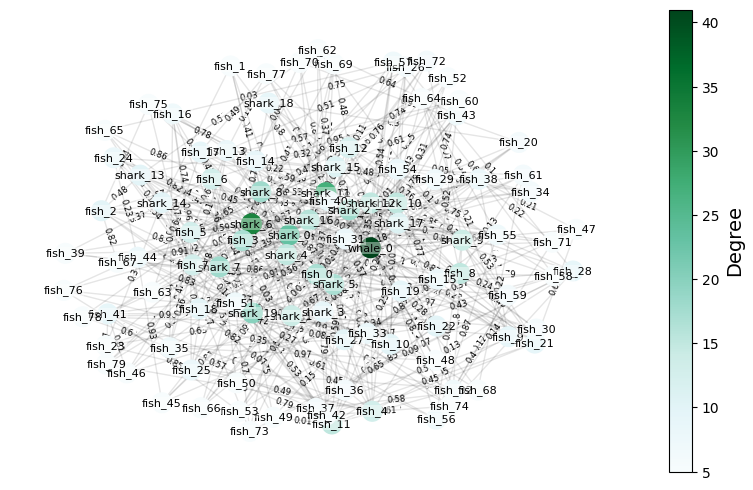

Progress: 0/500
Progress: 100/500
Progress: 200/500
Progress: 300/500
Progress: 400/500
CPU times: user 5min 59s, sys: 332 ms, total: 5min 59s
Wall time: 5min 59s


In [87]:
%%time
random.seed(42)

progress = 0
for run in range(1):
    model = Market_Model(
        N_agents = 100,
        mu = 0.03,
        N_init_edges = 5,
        Price = 10,
        p_sharks = 0.20,
        p_whales = 0.01,
        WPS = 10, # whale DOFs
        N_orders_thr = 10,
        mean_popularity_thr = 10, # shark DOFs
        points_change_belief = 5,
        prob_update_contacts = 0.01,
        mean_trust_thr = 0.50,  # fish DOFs
        prob_tobe_influenced = 0.80,
        prob_update_friends = 0.20
    )
    N_steps = 500
    for step in range(N_steps):
        if step >= progress:
            print(f'Progress: {progress}/{N_steps}')
            progress += 100
            
        model.step()

In [88]:
agent_vars = model.datacollector.get_agent_vars_dataframe()
model_vars = model.datacollector.get_model_vars_dataframe()

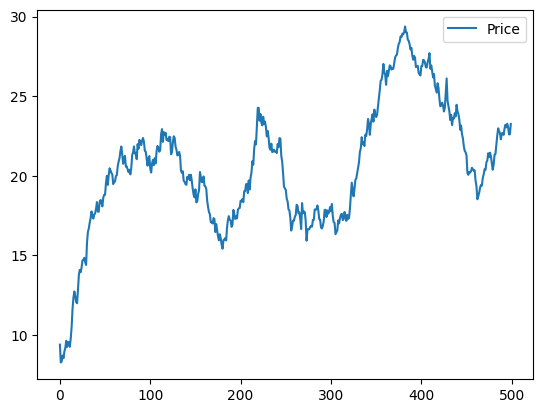

In [89]:
model_vars.plot();
#plt.yscale('log')

In [90]:
model_vars.to_csv('../data/model_vars_tmp.csv')
agent_vars.to_csv('../data/agent_vars_tmp.csv')